### Data Prep

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn 
import torch.optim as optim

In [2]:
# File paths
TESTDIR = './../Data/Hyundai/'
TESTPATH = 'Lock/'
TESTSIG = 'keyfob_signal2023Y1022163258.raw'

Separate I from Q
- we only care about the "real" portion

Trim our samples to get rid of the noise from start and end of capture

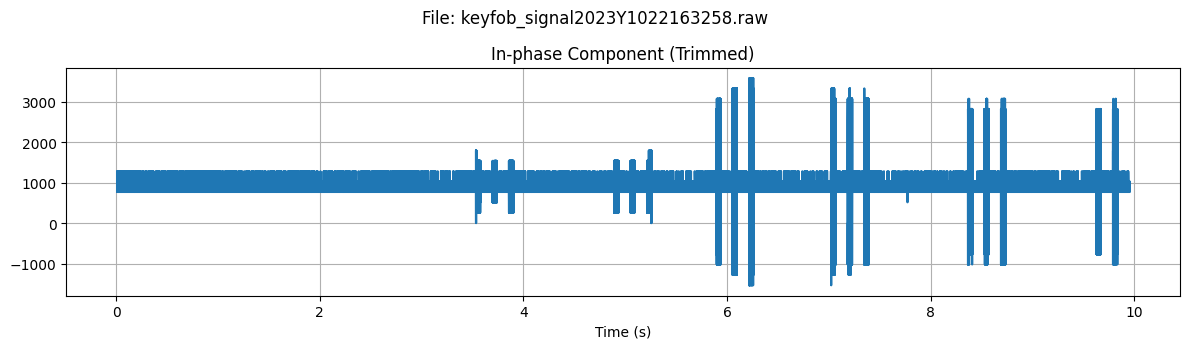

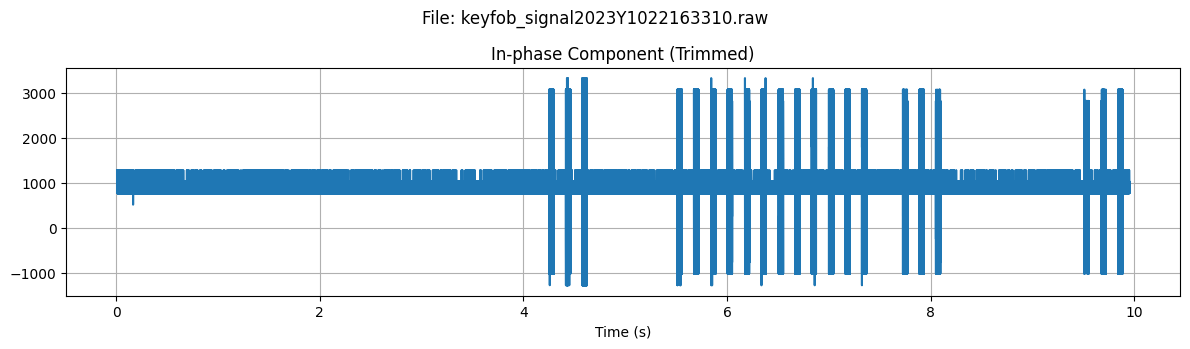

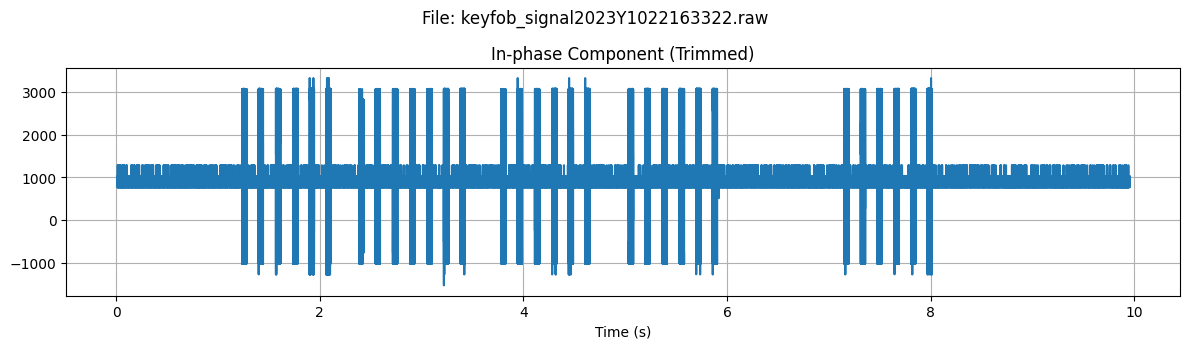

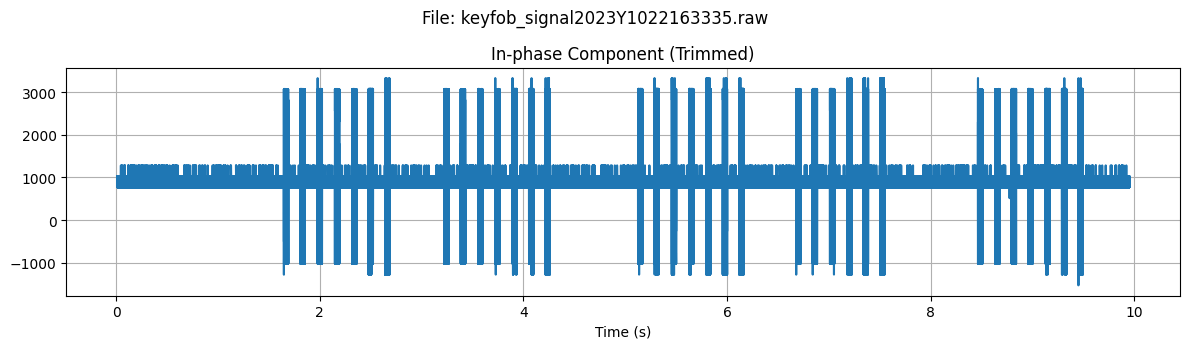

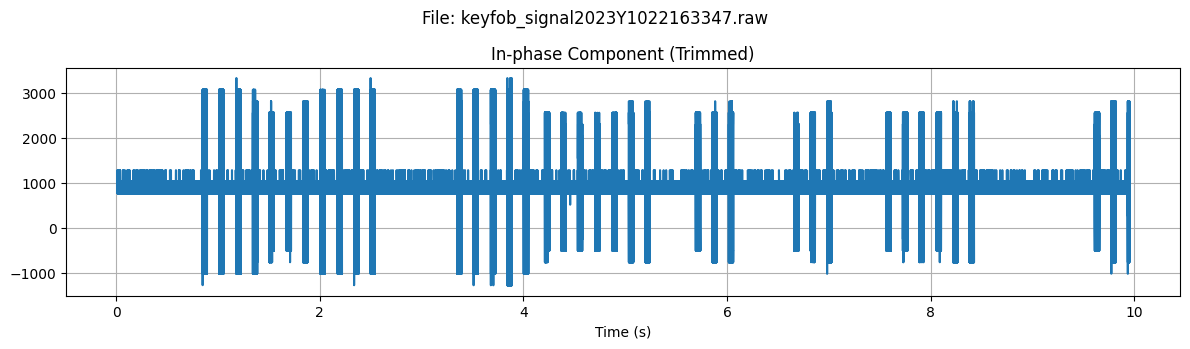

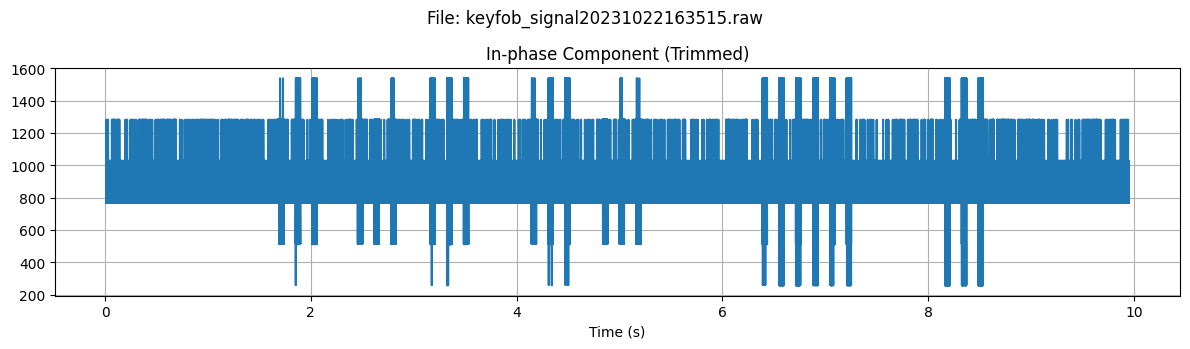

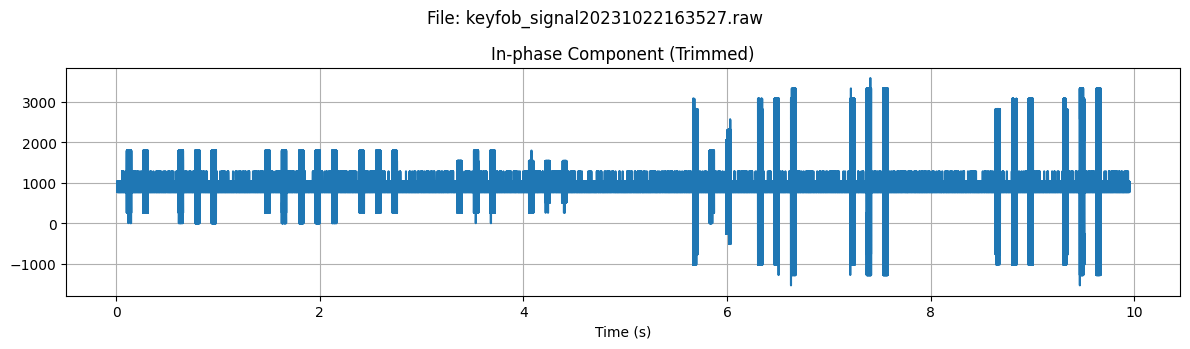

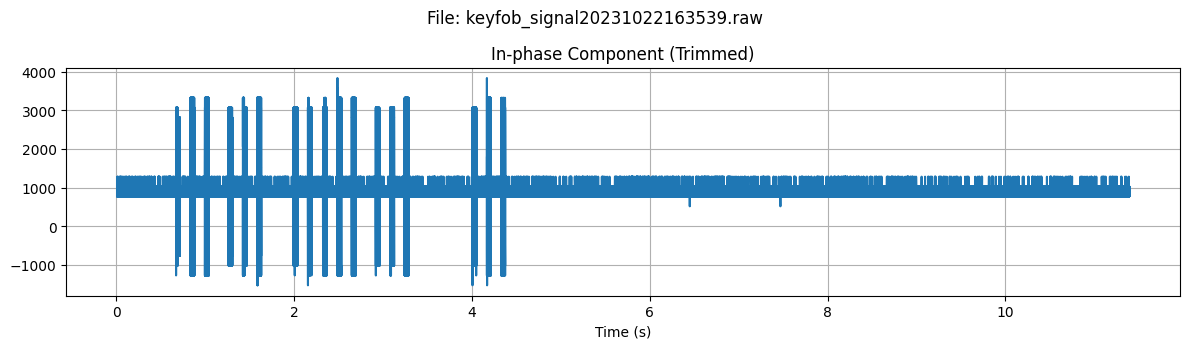

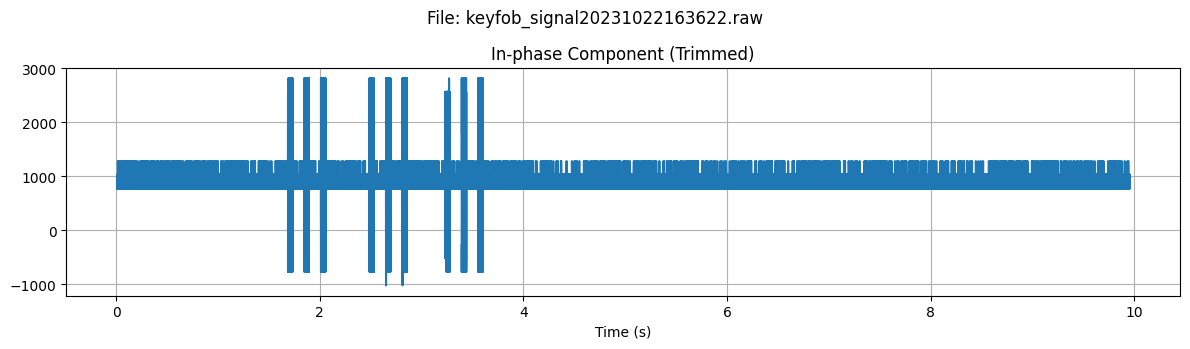

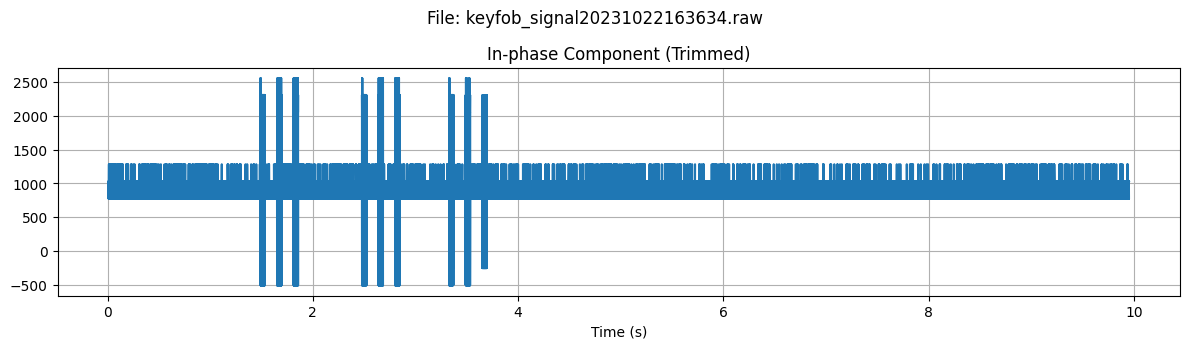

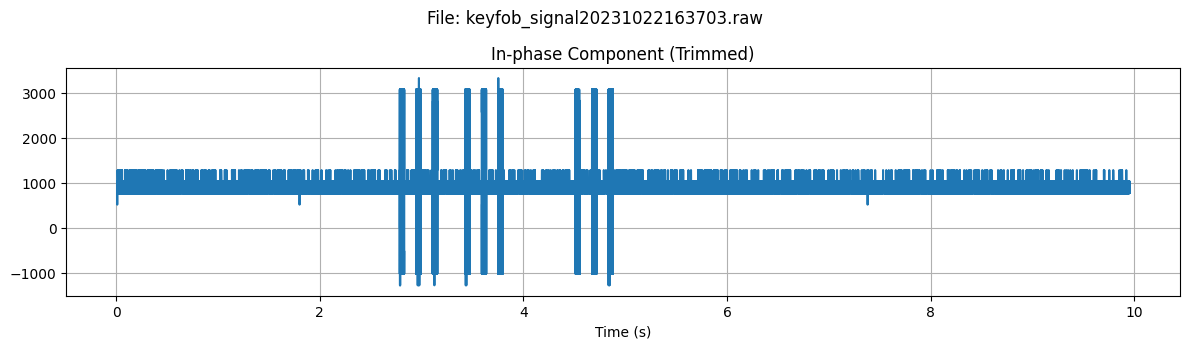

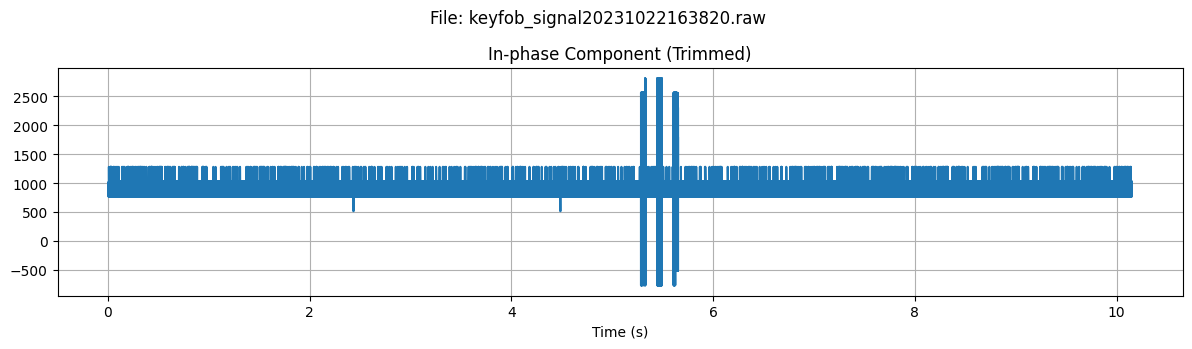

In [3]:
# Specify the path to your .raw file
data_dir = './../Data/Hyundai/Lock/'

# Get a list of all .raw files in the directory
raw_files = [file for file in os.listdir(data_dir) if file.endswith(".raw")]

# Loop through each .raw file in the directory
for raw_file in raw_files:
    file_path = os.path.join(data_dir, raw_file)

    # Read the raw file as bytes
    with open(file_path, 'rb') as file:
        raw_data = file.read()

    # Convert the raw data to a NumPy array of complex numbers
    # Assuming the raw data consists of interleaved I and Q samples (16-bit signed integers)
    raw_array = np.frombuffer(raw_data, dtype=np.int16).astype(np.complex64)

    # Extract the in-phase (I) and quadrature (Q) components
    I = raw_array.real
    Q = raw_array.imag

    # Create a time axis for the signal (assuming a fixed sample rate)
    sample_rate = 2e6  # Replace with your actual sample rate
    time = np.arange(0, len(I)) / sample_rate

    # Define the trim duration in seconds
    trim_start = 0.005  # 5 ms
    trim_end = 0.005    # 5 ms

    # Calculate the number of samples to trim
    trim_samples = int(sample_rate * (trim_start + trim_end))

    # Trim the signal
    I_trimmed = I[trim_samples:-trim_samples]
    Q_trimmed = Q[trim_samples:-trim_samples]
    time_trimmed = time[trim_samples:-trim_samples]

    # Plot the I and Q components
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'File: {raw_file}')
    plt.subplot(2, 1, 1)
    plt.plot(time_trimmed, I_trimmed)
    plt.title('In-phase Component (Trimmed)')
    plt.xlabel('Time (s)')
    plt.grid()

    """plt.subplot(2, 1, 2)
    plt.plot(time_trimmed, Q_trimmed)
    plt.title('Quadrature Component (Trimmed)')
    plt.xlabel('Time (s)')
    plt.grid()"""

    plt.tight_layout()
    plt.show()

Normalize our Data

In [4]:
# Create a Min-Max scaler
scaler = MinMaxScaler()

# Fit and transform the data (I)
I_scaled = scaler.fit_transform(I_trimmed.reshape(-1, 1))

Split our data

In [5]:
import torch.nn.utils.rnn as rnn_utils

def process_signals(signals):
    # Determine the maximum sequence length
    max_sequence_length = max(len(seq) for seq in signals)

    # Sort signals by length in descending order
    signals.sort(key=len, reverse=True)

    # Create a tensor with zero padding to the maximum length
    padded_signals = torch.zeros((len(signals), max_sequence_length), dtype=torch.float32)

    # Fill in the padded signals with the original data
    for i, signal in enumerate(signals):
        padded_signals[i, :len(signal)] = torch.tensor(signal, dtype=torch.float32)

    # Get the lengths of original signals for pack_padded_sequence
    signal_lengths = torch.tensor([len(signal) for signal in signals])

    # Use pack_padded_sequence to pack the padded signals
    packed_signals = rnn_utils.pack_padded_sequence(padded_signals, signal_lengths, batch_first=True, enforce_sorted=False)

    return packed_signals


In [6]:
def create_signal_dataframe(data_dir):
    I_data_list = []
    labels_list = []

    for category in os.listdir(data_dir):
        category_dir = os.path.join(data_dir, category)
        if os.path.isdir(category_dir):
            for file in os.listdir(category_dir):
                if file.endswith(".raw"):
                    file_path = os.path.join(category_dir, file)

                    with open(file_path, 'rb') as file:
                        raw_data = file.read()

                    raw_array = np.frombuffer(raw_data, dtype=np.int16).astype(np.complex64)
                    I_data = raw_array.real
                    Q_data = raw_array.imag

                    # Create a time axis for the signal (assuming a fixed sample rate)
                    sample_rate = 2e6  # Replace with your actual sample rate
                    time = np.arange(0, len(I_data)) / sample_rate

                    # Define the trim duration in seconds
                    trim_start = 0.005  # 5 ms
                    trim_end = 0.005    # 5 ms

                    # Calculate the number of samples to trim
                    trim_samples = int(sample_rate * (trim_start + trim_end))

                    # Trim the signal
                    I_trimmed = I_data[trim_samples:-trim_samples]
                    time_trimmed = time[trim_samples:-trim_samples]
                    #

                    # Pad the signal to the desired length
                    if len(I_trimmed) < 22766528:
                        pad_width = 22766528 - len(I_trimmed)
                        I_padded = np.pad(I_trimmed, (0, pad_width), 'constant')
                    else:
                        I_padded = I_trimmed

                    I_scaled = scaler.fit_transform(I_padded.reshape(-1,1))

                    I_data_list.append(I_scaled)
                    #I_data_list.append(I_trimmed)
                    # Process and pack the signals
                    labels_list.append(category)
    
    #processed_signals = process_signals(I_data_list)

    one_hot_labels = pd.get_dummies(labels_list, columns=['Label'])                

    df = pd.DataFrame({'Signal': I_data_list})
    #df = pd.DataFrame({'Signal': processed_signals})
    df = pd.concat([df, one_hot_labels], axis=1)
    
    return df

In [7]:
# Example usage
data_directory = TESTDIR  # Change this to the path of your 'Data' directory
hyundai_df = create_signal_dataframe(data_directory)

In [8]:
hyundai_df.head()

,Signal,Lock,Unlock
0,"[[0.5004884], [0.5004884], [0.5004884], [0.500...",True,False
1,"[[0.50032544], [0.50032544], [0.50032544], [0....",True,False
2,"[[0.5265323], [0.5265323], [0.5265323], [0.526...",True,False
3,"[[0.52592593], [0.52592593], [0.47325101], [0....",True,False
4,"[[0.5001084], [0.5001084], [0.5001084], [0.444...",True,False


In [9]:
hyundai_df_shuffled = hyundai_df.sample(frac=1, random_state=43).reset_index(drop=True)
hyundai_df_shuffled.head()

,Signal,Lock,Unlock
0,"[[0.5001626], [0.5001626], [0.5001626], [0.416...",False,True
1,"[[0.4663887], [0.5330901], [0.5330901], [0.533...",False,True
2,"[[0.5328125], [0.5328125], [0.5328125], [0.532...",True,False
3,"[[0.6662338], [0.6662338], [0.5], [0.6662338],...",True,False
4,"[[0.50009775], [0.4500489], [0.50009775], [0.5...",True,False


In [10]:
X = hyundai_df_shuffled['Signal'].values
y = hyundai_df_shuffled.drop('Signal',axis=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=43,
)

In [12]:

test = max(X_train,key=len)

In [13]:
X_train[0].size

22766528

In [14]:
from torch.utils.data import DataLoader, Dataset

class RFSignalDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        sample = {'data': data, 'label': self.labels[index]}
        return sample

# Define a custom neural network model
class RFSignalClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(RFSignalClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [19]:
# Create datasets and data loaders
train_dataset = RFSignalDataset(X_train, y_train)
test_dataset = RFSignalDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Initialize the model and optimizer
input_size = X_train[0].size  # Specify the input size based on your X_train shape
num_classes = 3 # Specify the number of classes
model = RFSignalClassifier(input_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # For classification tasks

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        data = batch['data']
        labels = batch['label']
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop (optional)
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for batch in test_loader:
            data = batch['data']
            labels = batch['label']
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')

KeyError: 11

In [ ]:
# Save the trained model
#torch.save(model.state_dict(), 'rf_signal_classifier.pth')